In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)

sns.set_style("white")

np.random.seed(0)

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.0 scipy==1.11.3 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.2 louvain==0.8.1 pynndescent==0.5.11


In [2]:
adata = sc.read_h5ad('D:/st_projects/data/Starmap/STARmap_20180505_BY3_1k.h5ad')
adata.X = sparse.csr_matrix(adata.X)
sc.pp.normalize_total(adata, inplace=True)
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    uns: 'label_colors'
    obsm: 'spatial'

In [3]:
# banksy preprocess
from sklearn.neighbors import NearestNeighbors

visualize_weights = True
num_neighbours = 8

nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
median_cell_distance = np.median(distances)
print(f"\nMedian distance to closest cell = {median_cell_distance}")
distances.shape, indices.shape


Median distance to closest cell = 316.6983136920192


((1207, 8), (1207, 8))

Maximum weight: 0.3239568426212327


(-630.5286230210681, 14490.623535171215, -6754.970494562382, 282.2613648040552)

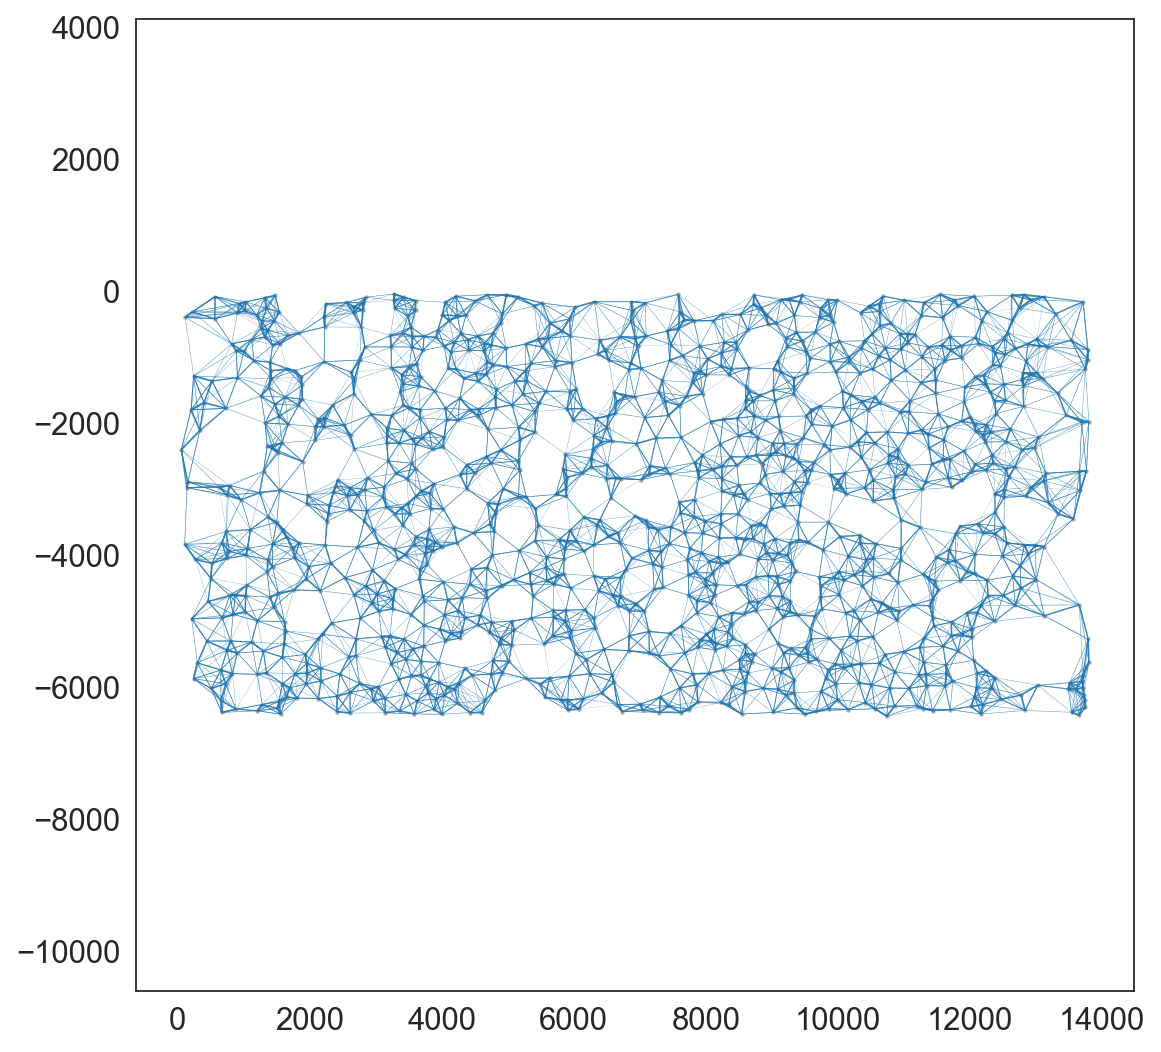

In [4]:
from utils import generate_spatial_weights_fixed_nbrs, plot_graph_weights

weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(adata.obsm['spatial'], num_neighbours=num_neighbours, decay_type='scaled_gaussian', nbr_object=nbrs, verbose=False)
position = adata.obsm['spatial'].copy()
plot_graph_weights(position, sparse.csr_matrix(np.nan_to_num(weights_graph.A)), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [5]:
from utils import weighted_concatenate, zscore, matrix_to_adata

gene_list = adata.var.index

nbrhood_contribution = 0.8

neighbour_agg_matrix = weights_graph @ adata.X

if sparse.issparse(adata.X):
    concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
else:
    concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

matrix = weighted_concatenate(zscore(adata.X, axis=0), zscore(neighbour_agg_matrix, axis=0), nbrhood_contribution)


if sparse.issparse(matrix):
    st_dev_pergene = matrix.toarray().std(axis=0)
else:
    st_dev_pergene = matrix.std(axis=0)

enhanced_data = matrix_to_adata(matrix, adata)
display(enhanced_data)

num_nbrs: 1020


AnnData object with n_obs × n_vars = 1207 × 2040
    obs: 'Total_counts', 'X', 'Y', 'label'
    var: 'is_nbr'
    uns: 'label_colors'
    obsm: 'spatial'

In [6]:
sc.pp.pca(enhanced_data, n_comps=20)
low_dim_x = enhanced_data.obsm['X_pca']

computing PCA
    with n_comps=20
    finished (0:00:00)


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

n_spot = low_dim_x.shape[0]
n_neighbor = 15
init_W = cosine_similarity(low_dim_x)
cos_init = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = init_W[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        cos_init[i, y] = init_W[i, y]

In [8]:
from MNMST_gpu import sparse_self_representation_torch, MNMST_representation_gpu

import torch

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
cos_init_tensor = torch.from_numpy(cos_init).float().to(device)
x_tensor = torch.from_numpy(low_dim_x.T.copy()).to(device)
C_gpu = sparse_self_representation_torch(x_tensor, init_w=cos_init_tensor, alpha=1., beta=10., device=device)

spatia_init_tensor = torch.from_numpy(weights_graph.A).float().to(device)
Z_gpu = MNMST_representation_gpu(C_gpu, spatia_init_tensor, device=device)

# Epoch 19, loss: 0.078:  20%|██        | 20/100 [00:00<00:02, 33.58it/s]


In [9]:
Z_gpu = Z_gpu.detach().cpu().numpy()

running Leiden clustering
    finished: found 7 clusters and added
    'MNMST_GPU', the cluster labels (adata.obs, categorical) (0:00:00)
Cell_9       1
Cell_10      0
Cell_13      3
Cell_15      1
Cell_16      4
            ..
Cell_1382    1
Cell_1383    1
Cell_1385    3
Cell_1387    6
Cell_1390    5
Name: MNMST_GPU, Length: 1207, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


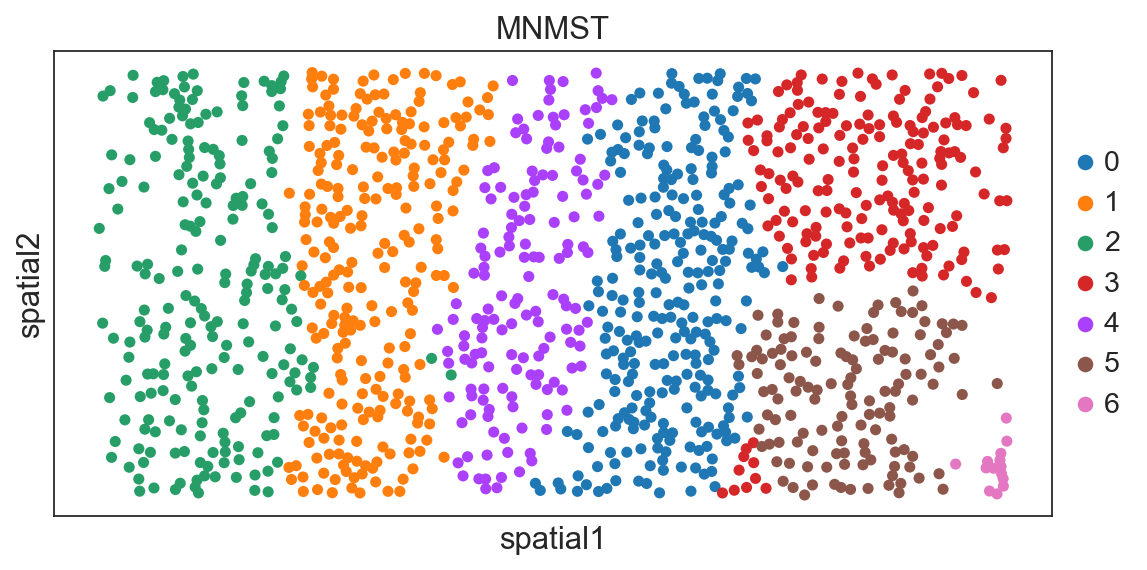

In [10]:
key_added = 'representation'
conns_key = 'representation'
dists_key = 'representation'

enhanced_data.uns[key_added] = {}
    
representation_dict = enhanced_data.uns[key_added]
    
representation_dict['connectivities_key'] = conns_key
representation_dict['distances_key'] = dists_key
representation_dict['var_names_use'] = enhanced_data.var_names.to_numpy()
    
representation_dict['params'] = {}
representation_dict['params']['method'] = 'umap'
enhanced_data.obsp['representation'] = Z_gpu
sc.tl.leiden(enhanced_data, neighbors_key='representation', resolution=0.43, key_added='MNMST_GPU')
print(enhanced_data.obs['MNMST_GPU'])
sc.pl.embedding(enhanced_data, basis='spatial', color=['MNMST_GPU'], show=False, size=100, title='MNMST')
plt.gca().set_aspect('equal', adjustable='box')

In [11]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(pd.Categorical(enhanced_data.obs['label']).codes, enhanced_data.obs['MNMST_GPU'])

0.6135220113083693